In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

from copy import deepcopy

from helpers_preprocessing import *
from helpers_postprocessing import *
from helpers_clustering import *
from helpers_plot import *
from helpers_modelweek import *
from helpers_linear_regression import *
from building_routine import analyze_building

%matplotlib inline
%load_ext autoreload
%autoreload 2


# 1. Data loading and cleaning

## 1.1 Load and clean the full dataset

+ `data_raw`: contains all rows and columns (headers removed in the .csv)
+ `data`: output resulting after selecting only energy consumption columns and applying row cleaning (wrong measurement times are deleted)
+ `data_clean`: dataset containing only columns (buildings) from `data` that do not have NaN measurements

In [3]:
# Load the raw dataset
data_path = "data/data.csv"
data_raw = load_data(data_path)

Shape of raw dataset: 
 (68555, 835)


In [4]:
# Import the columns indices that we need to use from external file...
data_col = pd.read_csv('data/columns.csv', header=None)
# ...and select only columns related to energy consumption
# column 0 correspond to measurement time, all the others are single building measurenets
energy_consumption_columns = np.concatenate(([0], np.hstack(data_col.to_numpy())))

# Format raw dataset by:
# 1) selecting only columns related to energy consumption 
# 2) casting index to datetime
# 3) removing wrong measurements (duplicated rows, missing time records)
# 4) dropping last 6 days in order to have complete weeks
data_with_NaNs = format_data(data_raw, energy_consumption_columns)

# Discard columns which contains more than max_NaNs, otherwise fill empty values with pd.fillna()
# selected_columns is used to link results to the corresponding building in the raw dataset
max_NaNs = 30
data_no_NaNs, selected_columns = NaN_handling(data_with_NaNs, max_NaNs, energy_consumption_columns)

# Discard columns representing small buildings (setting the threshold for the mean energy consupmtion)
minimum_mean_energy_consumption = 10
data_no_small, selected_columns = remove_small_buildings(data_no_NaNs, minimum_mean_energy_consumption, selected_columns)

# Rename columns as "building_" + N, where N in [0, #columns-1]
data_renumbered = renumber_columns(data_no_small)

# Rename the processed dataset
data = data_renumbered

data.head(3)

FORMATTING DATA...
Index (datetime) unique: 
 True
Shape of formatted dataset: 
 (65856, 145)
First measurement: 
 2018-01-01 00:00:00
Last measurement: 
 2019-11-17 23:45:00

REMOVING NANS...
Number of dropped columns: 
 32
Shape of dataset after NaN handling: 
 (65856, 113)

REMOVING SMALL BULIDINGS...
Number of dropped columns: 
 8
Shape of dataset after removing small buildings: 
 (65856, 105)

RENUMBERING COLUMNS...
Total number of buildings: 
 105


,building_1,building_2,building_3,building_4,building_5,building_6,building_7,building_8,building_9,building_10,...,building_96,building_97,building_98,building_99,building_100,building_101,building_102,building_103,building_104,building_105
Time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,16.0,7.00,69.000003,45.600002,80.0,20.400001,50.1,60.0,56.0,12.600001,...,12.0,6.2,160.532151,21.000001,5.4,7.68,8.788643,20.0,24.600001,15.900001
2018-01-01 00:15:00,20.0,6.68,68.400003,40.800002,92.0,19.800001,50.7,56.0,60.0,14.100001,...,11.7,7.4,143.521595,21.000001,4.8,7.20,4.828815,20.4,25.200001,16.200001
2018-01-01 00:30:00,16.0,7.04,82.800003,45.600002,84.0,20.400001,50.4,56.0,104.0,15.000001,...,11.7,6.0,144.478405,21.000001,5.1,7.92,4.351567,19.6,25.200001,15.900001


In [5]:
# choiche of the building (i.e. the time series) to analyse, it must be an integer in range
# [1, Total number of buildings]

building_number = 1
data_per_day = 96
data_per_week = data_per_day*7

# creation of new dataset containing only the energy consumption of one building
# indexed on the time of the measurement.
# for every measurement is indicated the number of the week from which it belongs
energy_consumptions, total_weeks = create_single_building_dataframe(data, building_number, data_per_week)
energy_consumptions.head(3)


,consumption,week
Time,,
2018-01-01 00:00:00,16.0,0
2018-01-01 00:15:00,20.0,0
2018-01-01 00:30:00,16.0,0


----
# 2. Grid search for DBSCAN parameter epsilon


In [6]:
first_singular_value_multiplier = 0.012
principal_components_number = 2

# FT + PCA on selected building
PCA_weeks, S = compressed_week_representation(energy_consumptions, principal_components_number, data_per_week, total_weeks)



In [14]:
#parameters definition
percentage_variation = 0.1
total_iterations = 10
clusters_number = []
first_epsilon = S[0]*first_singular_value_multiplier*(1-percentage_variation)
last_epsilon = S[0]*first_singular_value_multiplier*(1+percentage_variation)

Epsilon:  158.23846764136715
Epsilon / S[0]:  0.010799999999999999
Clusters number:  2


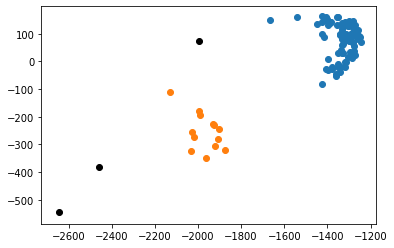

Epsilon:  165.2712884254279
Epsilon / S[0]:  0.011279999999999998
Clusters number:  2


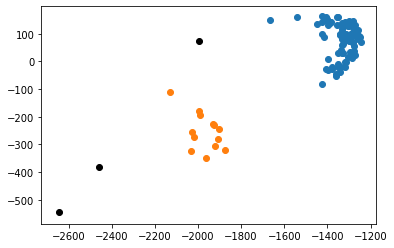

Epsilon:  172.30410920948867
Epsilon / S[0]:  0.011759999999999998
Clusters number:  2


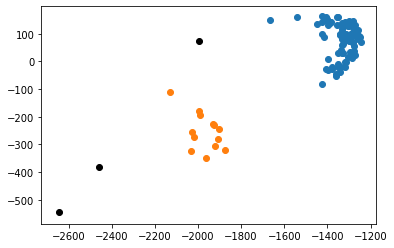

Epsilon:  179.33692999354946
Epsilon / S[0]:  0.012240000000000001
Clusters number:  2


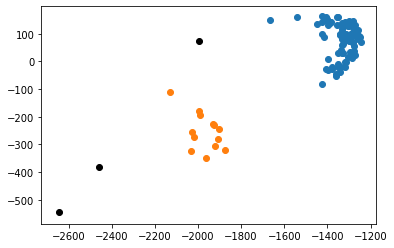

Epsilon:  186.36975077761022
Epsilon / S[0]:  0.01272
Clusters number:  2


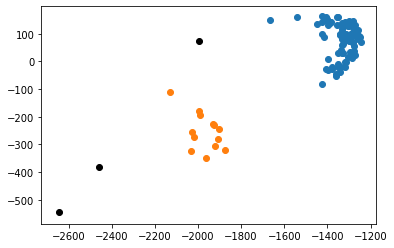

Epsilon:  193.40257156167098
Epsilon / S[0]:  0.0132
Clusters number:  2


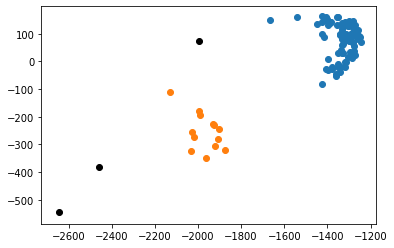

In [13]:
for iteration, epsilon in enumerate(np.linspace(first_epsilon, last_epsilon, total_iterations).tolist()):
    clustering = DBSCAN(eps=epsilon, min_samples=9).fit(PCA_weeks.T)
    clusters_number.append(np.max(clustering.labels_)+1)
    
    # Assign each week to a cluster
    max_cluster_index = np.max(clustering.labels_)
    n_clusters = max_cluster_index + 1
    clusters = []
    for cluster_index in range(0, n_clusters):
        clusters.append(clustering.labels_ == cluster_index)
    outliers = clustering.labels_ == -1

    # Reorder clusters based on their cardinality
    # (the bigger one should contain normal weeks and will be plotted in blue; 
    # outliers are excluded, always plotted in black)
    clusters_cardinalities = []
    for i in range(0, len(clusters)):
        clusters_cardinalities.append(clusters[i].sum())
    sorted_indices = np.array(clusters_cardinalities).argsort().tolist()
    ordered_clusters = []
    for i in range(len(clusters)-1, -1, -1):
        ordered_clusters.append(clusters[sorted_indices[i]])
    
    # Print parameters info and clustering coefficients
    print("Epsilon: ", epsilon)
    print("Epsilon / S[0]: ", epsilon / S[0])
    print("Clusters number: ", clusters_number[iteration])
    outliers_mask = clustering.labels_ == -1
    inlier_PCA_weeks = PCA_weeks[:, ~outliers_mask]
    inlier_labels = clustering.labels_[~outliers_mask]

    # Scatterplot the result
    for cluster_index in range(0, max_cluster_index+1):
        plt.scatter(PCA_weeks[0, ordered_clusters[cluster_index]], PCA_weeks[1, ordered_clusters[cluster_index]])
    plt.scatter(PCA_weeks[0, outliers], PCA_weeks[1, outliers], color='black')
    plt.show()